In [41]:
from stats2024.data_loader import load 

import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 

In [42]:
df = load('enem_scores.csv')
df

,year,school_id,number_of_students,avg_score
0,2007,11000058,144,69.03
1,2006,11000058,184,57.82
2,2005,11000058,220,64.83
3,2006,11000198,51,51.69
4,2005,11000198,47,50.16
...,...,...,...,...
37936,2006,53013999,177,59.81
37937,2007,53013999,131,73.18
37938,2005,53014111,131,57.61
37939,2006,53014111,181,54.38


In [4]:
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


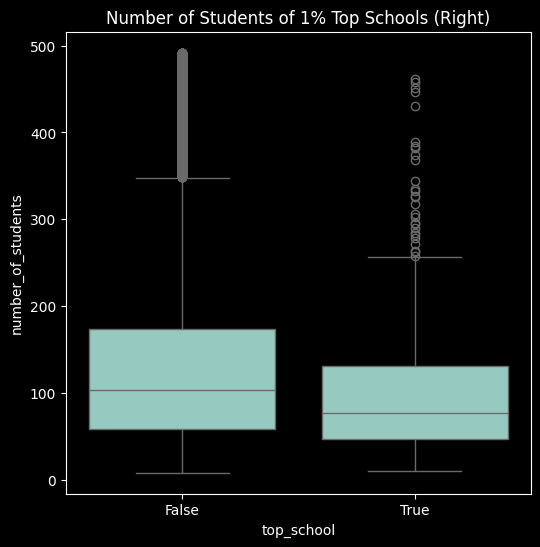

In [10]:

plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

In [17]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

q_99, q_01

(71.15, 32.184)

In [18]:
plot_data = (df
    .sample(10000)
    .assign(
        Group = lambda d: np.select(
            [d["avg_score"] > q_99, d["avg_score"] < q_01],
            ["Top", "Bottom"], 
            "Middle"
        )
    )
)

plot_data

,year,school_id,number_of_students,avg_score,Group
21384,2005,35021623,88,48.30,Middle
4141,2006,23081945,406,40.32,Middle
30053,2007,41070062,78,51.56,Middle
25319,2007,35114522,38,64.57,Middle
11349,2005,31023736,241,48.84,Middle
...,...,...,...,...,...
22802,2007,35033388,60,49.69,Middle
21335,2007,35021124,41,50.73,Middle
8065,2006,27036782,373,39.99,Middle
26854,2006,35172716,41,63.56,Middle


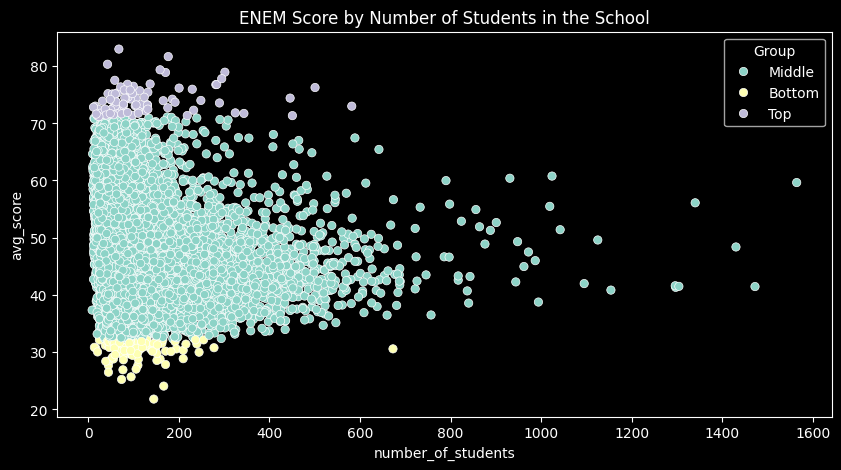

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

In [27]:
data = pd.read_csv("data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


Notes:
- apply function to series
- [] gives series, [[]] gives dataframe

Experiment to understand sampling from a true-abstract distribution

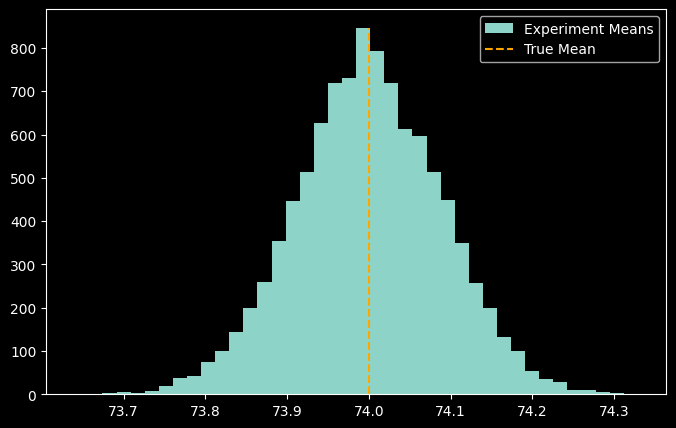

In [28]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

We take 10,000 experiments (samples), each sampling 500 from population of the true abstract distribution. The distrubtion of means of these samples is plotted against the true mean. We can see the distribution of means is normal (CTL).

Standard error (mourive equation) is the standard deviation of sample means from all the experiments. We can simply construct a confidence interval of the estimate mean by sample_mean +- 1.96 (se)

In [30]:
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.7291385613484, 74.10237942496437)


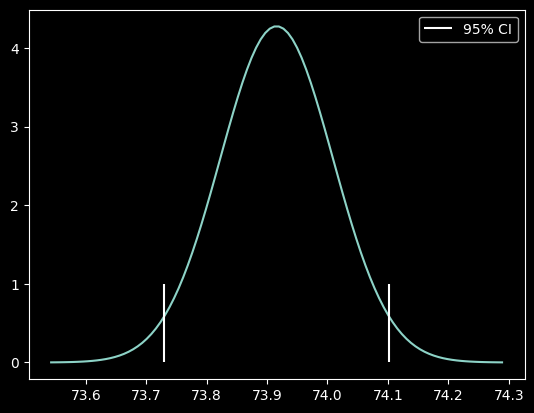

In [33]:
from scipy import stats

x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

In [34]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


## Hypothesis testing 

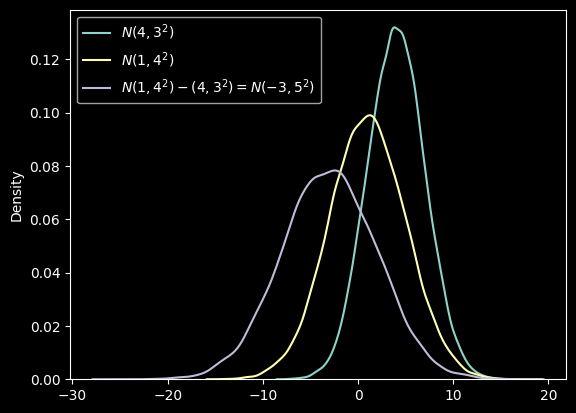

In [37]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

- Sum/Diff of 2 normal distributions is normal
- sum of 2 normals adds the standard deviation together
- difference of 2 normals takes standard deviation as sqrt of sum of std 

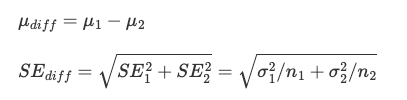

In [38]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


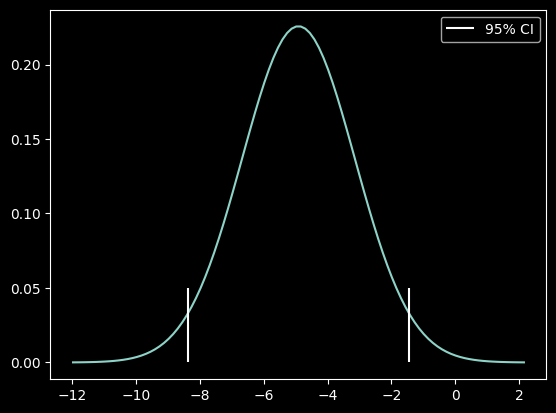

In [39]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

Above shows confidence interval for difference between the means.

Z-statstic can be calculated as: 
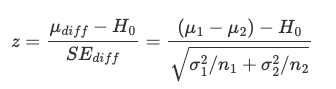

In [40]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383
